# cis-isoQTL analysis
- Expression processing

After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot
- Compare sig feature across ancestries, upsetR
- Venn graph for fetal vs PEC, GTEx
- isoGene type
- Conditional pass
- Susie

In [90]:
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))
suppressMessages(library(patchwork))
# suppressMessages(library(ggridges))
suppressMessages(library(DESeq2))
suppressMessages(library(WGCNA))
suppressMessages(library(sva))
suppressMessages(library(edgeR))

In [2]:
setwd("~/project-gandalm/isoform_twas/isoqtl_new/")

### 1: Expression processing

In [86]:
datExpr <- fread("../salmon/expression.final/tx.counts.scaled.tsv", data.table = F)
gtf <- fread("../salmon/gencode.tx.tsv", data.table = F)

# remove chrM, chrX, chrY
# walker and hdbr duplicate 1707
# make hdbr 1707.1
names(datExpr)[647] <- "1707.1"
gtf <- gtf %>% filter(!(V1 %in% c("chrX","chrY","chrM")))
datExpr <- datExpr %>% filter(V1 %in% gtf$V5)
gtf <- gtf %>% filter(V5 %in% datExpr$V1)

rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
datExpr <- round(datExpr)

dim(gtf)
dim(datExpr)

Warning message in fread("../salmon/expression.final/tx.counts.scaled.tsv", data.table = F):
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] 220872      5

[1] 220872    654

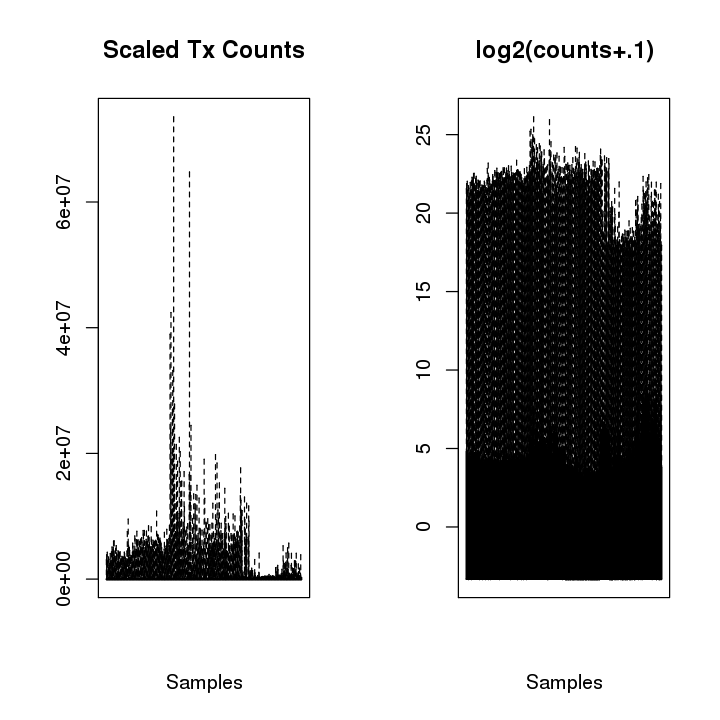

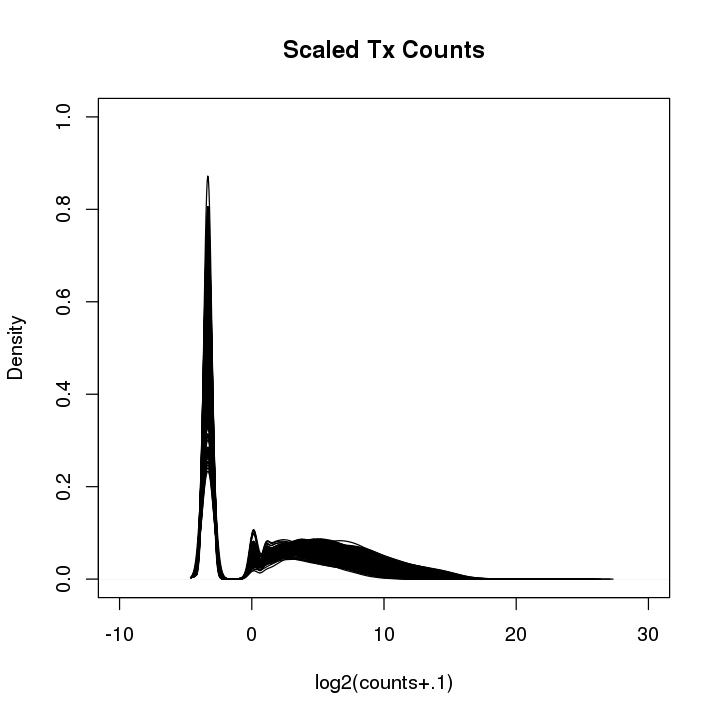

In [21]:
options(repr.plot.height = 6, repr.plot.width = 6)
# View the distribution of expression for each sample.
# box plot, looking for big differences in read depth (raw counts), symmetry in distribution across samples
par(mfrow=c(1,2))
boxplot(datExpr, range = 0, main = 'Scaled Tx Counts', xlab = 'Samples', xaxt = "n")
boxplot(log2(.1+datExpr), range = 0, main = 'log2(counts+.1)', xlab = 'Samples', xaxt = "n")

# Histogram/density plot
# Look for: how well do the distributions line up, outlier samples, zero counts
par(mfrow=c(1,1))
i <- 1
plot(density(log2(.1+datExpr[,i])), main = 'Scaled Tx Counts', xlab = 'log2(counts+.1)', 
     xlim = c(-10,30), ylim = c(0,1))
for(i in 2:ncol(datExpr)){
  lines(density(log2(.1+datExpr[,i])))
}

In [87]:
# Remove lowly expressed
datExpr.tpm <- fread("../salmon/expression.final/tx.TPM.tsv", data.table = F)
names(datExpr.tpm)[647] <- "1707.1"
datExpr.tpm <- datExpr.tpm %>% filter(V1 %in% gtf$V5)
rownames(datExpr.tpm) <- datExpr.tpm$V1
datExpr.tpm <- datExpr.tpm[,-1]

Warning message in fread("../salmon/expression.final/tx.TPM.tsv", data.table = F):
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [23]:
# Select cutoff
# cutoff = 0
cut0_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 0)) > i*dim(datExpr.tpm)[2]
  cut0_df[which(cut0_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut0_df$cutoff <- rep(0, 10)

# cutoff = 0.1
cut1_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .1)) > i*dim(datExpr.tpm)[2]
  cut1_df[which(cut1_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut1_df$cutoff <- rep(.1, 10)

# cutoff = 0.5
cut5_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .5)) > i*dim(datExpr.tpm)[2]
  cut5_df[which(cut5_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut5_df$cutoff <- rep(.5, 10)

# cutoff = 1
cut10_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 1)) > i*dim(datExpr.tpm)[2]
  cut10_df[which(cut10_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut10_df$cutoff <- rep(1, 10)


cut_df <- rbind(cut0_df, cut1_df, cut5_df, cut10_df)
cut_df$cutoff <- as.factor(cut_df$cutoff)

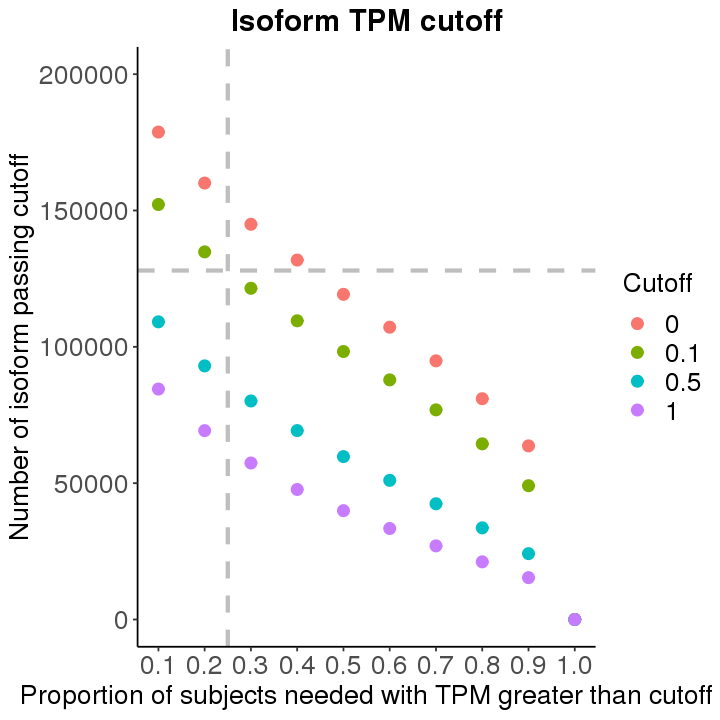

In [25]:
p <- ggplot(cut_df, aes(x = subjProportion, y = numFeature, color = cutoff)) +
  geom_point(size = 3) +
  labs(x = "Proportion of subjects needed with TPM greater than cutoff",
       y = "Number of isoform passing cutoff",
       title = "Isoform TPM cutoff",
       color = "Cutoff") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        axis.title = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        legend.title = element_text(size=16),
         legend.text = element_text(size=16)) +
  scale_x_continuous(breaks = seq(0,1,0.1)) +
  ylim(0,200000) +
  geom_vline(xintercept = 0.25, linetype = "dashed", color = "grey", size = 1.2) +
  geom_hline(yintercept = 127986, linetype = "dashed", color = "grey", size = 1.2)
p

In [26]:
ggsave("figures/cutoff.png", p, width = 6, height = 6)

In [88]:
# cutoff=0.1, 25% subjects
keep <- (rowSums(datExpr.tpm > .1)) > 0.25*ncol(datExpr.tpm)
table(keep)

keep
 FALSE   TRUE 
 92886 127986 

In [89]:
datExpr <- datExpr[keep,]
datExpr.tpm <- datExpr.tpm[keep,]

In [96]:
# use varianceStabilizingTransformation in actual script
# datExpr.vst <- vst(as.matrix(datExpr), blind = TRUE)
datExpr.vst <- varianceStabilizingTransformation(as.matrix(datExpr), blind = TRUE)
# meanSdPlot(as.matrix(datExpr.vst))
datExpr.vst <- as.data.frame(datExpr.vst)

converting counts to integer mode



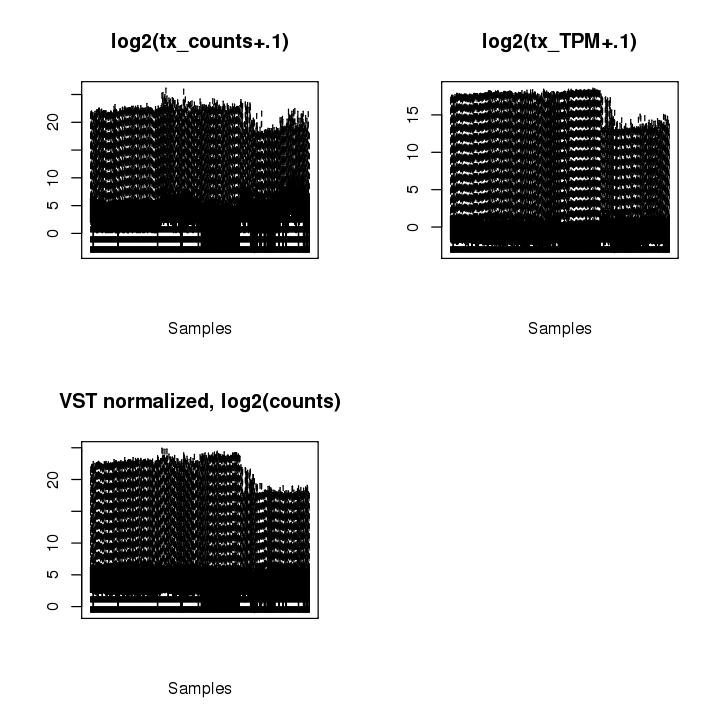

In [97]:
# check depth normalization, in log2 scale
par(mfrow=c(2, 2))
boxplot(log2(.1+datExpr), range=0, main = "log2(tx_counts+.1)", xlab="Samples",xaxt="n")
boxplot(log2(.1+datExpr.tpm), range=0, main = "log2(tx_TPM+.1)", xlab="Samples",xaxt="n")
# boxplot(datExpr.cpm, range=0, main = "TMM normalized, logCPM", xlab="Samples",xaxt="n")
boxplot(datExpr.vst, range=0, main = "VST normalized, log2(counts)", xlab="Samples",xaxt="n")

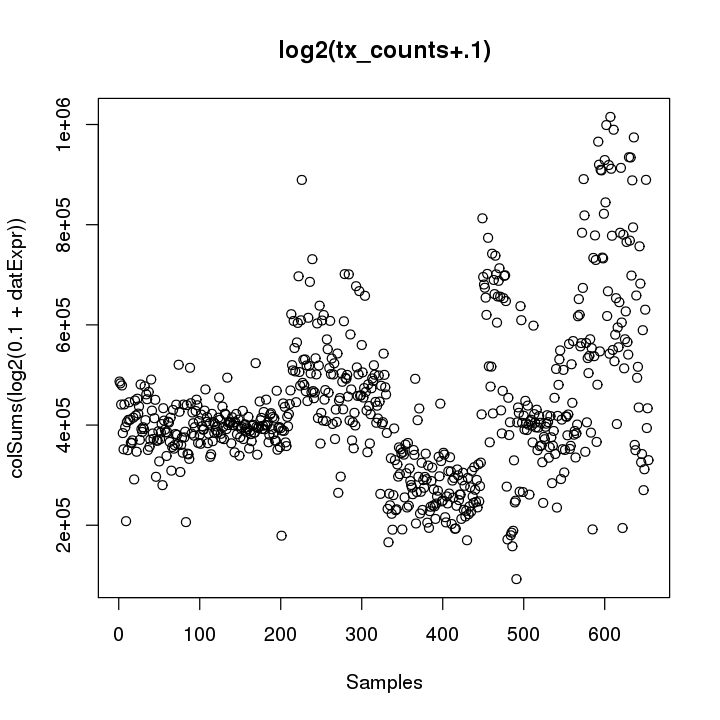

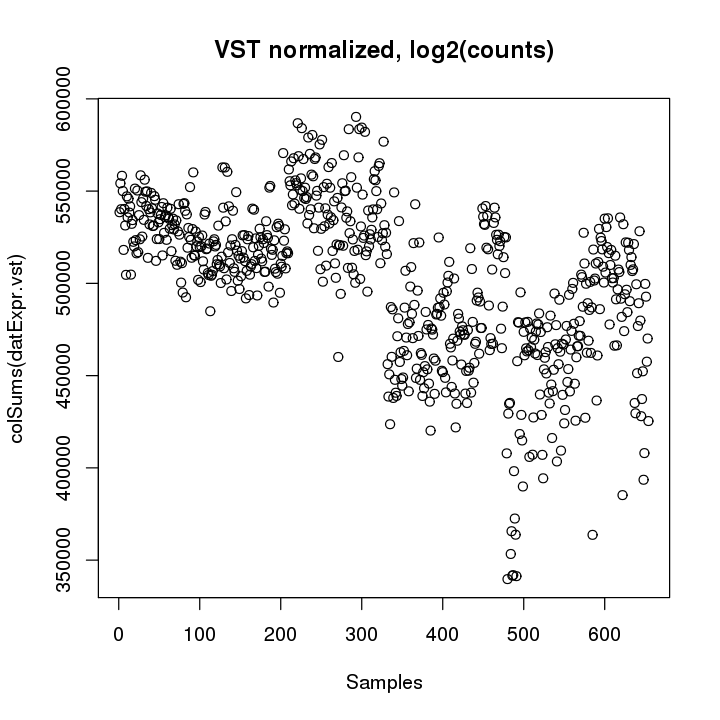

In [98]:
plot(colSums(log2(.1+datExpr)), main = "log2(tx_counts+.1)", xlab="Samples")
# plot(colSums(log2(.1+datExpr.tpm)), main = "log2(gene_TPM+.1)", xlab="Samples")
# plot(colSums(datExpr.tpm), main = "gene_TPM", xlab="Samples")
# plot(colSums(datExpr.cpm), main = "TMM normalized, logCPM", xlab = "Samples")
plot(colSums(datExpr.vst), main = "VST normalized, log2(counts)", xlab = "Samples")

In [99]:
# Outlier detection
normadj <- adjacency(datExpr.vst,type = 'signed',corFnc = 'bicor')   #Calculate network adjacency
netsummary <- fundamentalNetworkConcepts(normadj)
C <- netsummary$Connectivity   #Extract connectivity of each sample
Z.C <- (C-mean(C))/sqrt(var(C))   #Covert to Z-score

par(mfrow=c(1,1))
png("figures/outlier.png", width = 300, height = 300)
plot(1:length(Z.C), Z.C, main = "Outlier Plot", xlab = "Samples",ylab = "Connectivity Z Score", cex.main = 1.2)
abline(h=-3, col="red")
dev.off()

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


png 
  2

In [100]:
outliers <- (Z.C < -3)
outlier.df <- data.frame(c(which(outliers)))
outlier.df$c.which.outliers.. <- rownames(outlier.df)
outlier.df

,c.which.outliers..
,<chr>
17111,17111
17486,17486
HSB194,HSB194
HSB618,HSB618
Br2396,Br2396
Br2403,Br2403
Br2410,Br2410
Br2411,Br2411
Br2415,Br2415


**See `eqtl_analysis.ipynb` for plot after batch correction, and some other plots**

### 2: Optimal number of HCP

#### Mixed ancestry

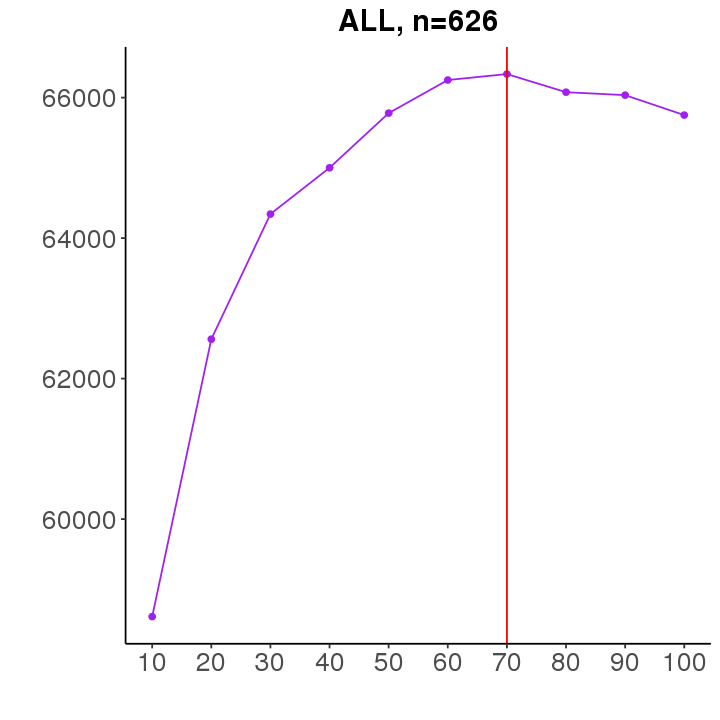

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6)
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 70, color = "red") +
    labs(title = "ALL, n=626",
         x = "",
         y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p1

In [4]:
# ggsave("figures/mixed_nominal.png", p1, width = 6, height = 6)

#### EUR

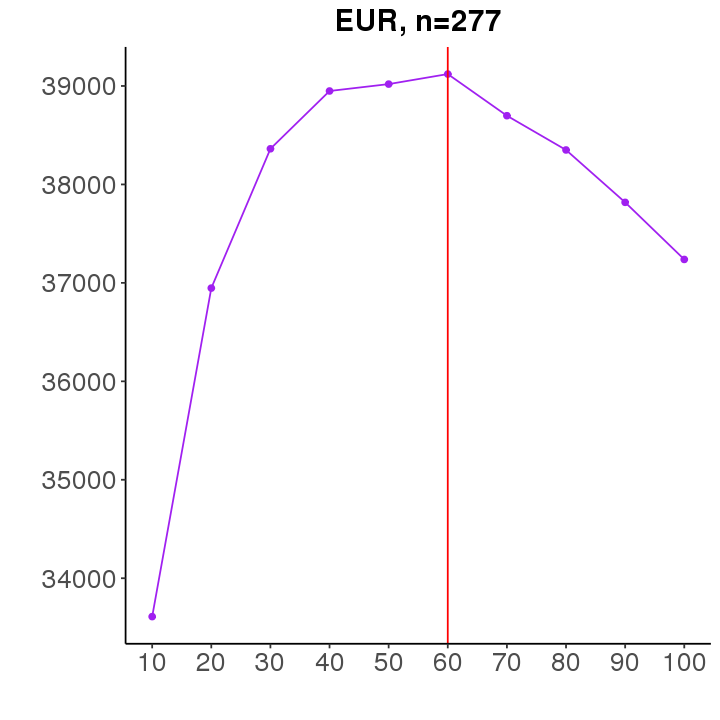

In [12]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p2 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 60, color = "red") +
    labs(title = "EUR, n=277",
         x = "",
         y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p2

In [5]:
# ggsave("figures/eur_nominal.png", p3, width = 6, height = 6)

#### AMR

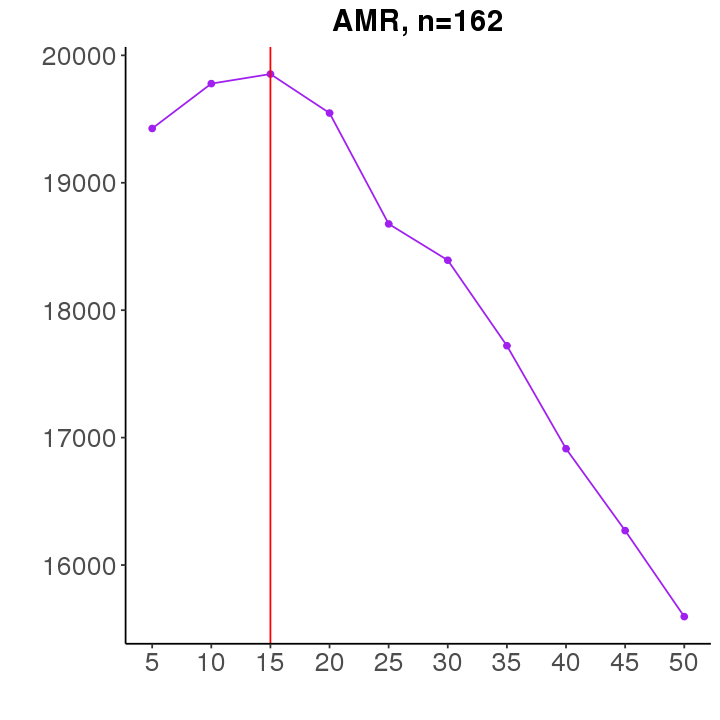

In [13]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR, n=162",
         x = "",
         y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p3

In [7]:
# ggsave("figures/amr_nominal.png", p4, width = 6, height = 6)

#### AFR

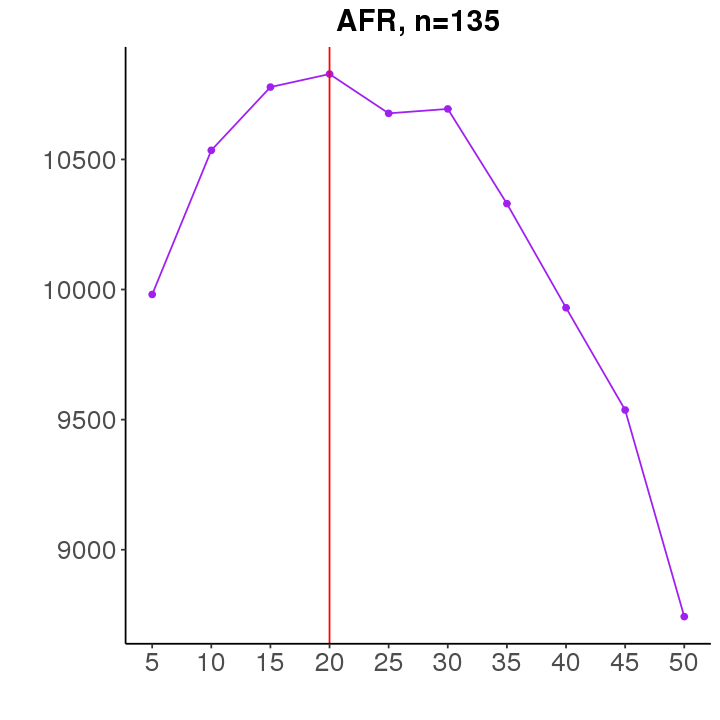

In [14]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "purple") +
    geom_line(aes(x=HCP, y=Count), color = "purple") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 20, color = "red") +
    labs(title = "AFR, n=135",
         x = "",
         y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p4

In [10]:
# ggsave("figures/afr_nominal.png", p5, width = 6, height = 6)

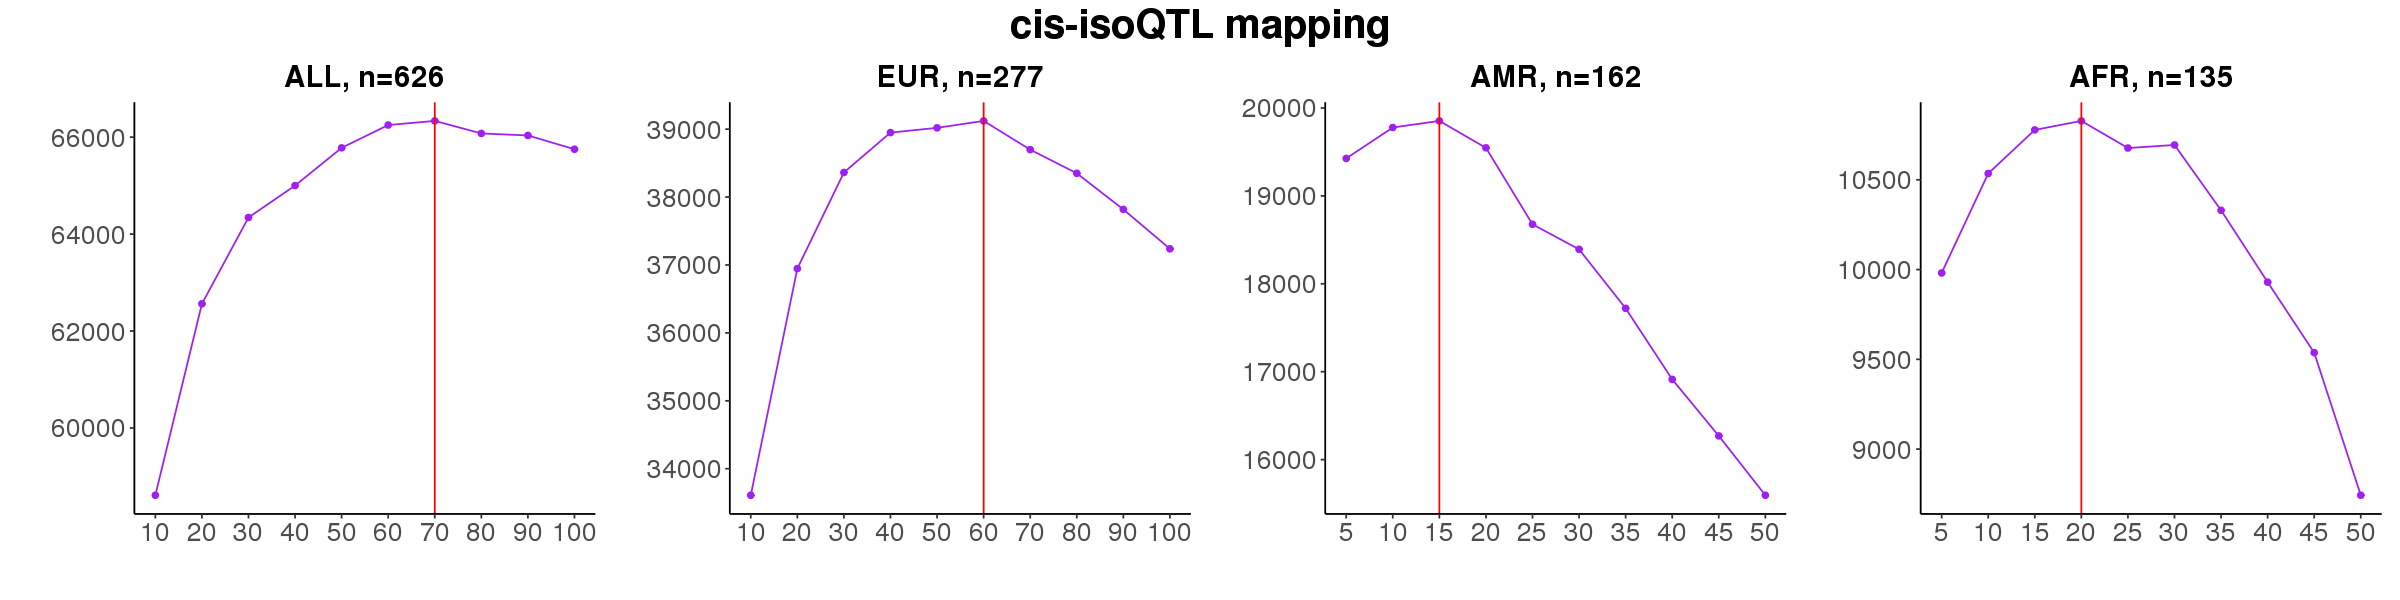

In [17]:
options(repr.plot.width=20, repr.plot.height=5)

p <- p1 + p2 + p3 + p4 +  
  plot_annotation(title = "cis-isoQTL mapping",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) +
  plot_layout(ncol = 4)

p

In [18]:
ggsave("figures/nominal.png", p, height = 5, width = 20)

### 3: Isoform expression regression, check batch effects

#### Mixed ancestry

In [27]:
rel <- read.table("../genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]

Warning message in fread("data/tx.counts.processed.tsv", data.table = F):
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 639 column names but the data has 640 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  77 626

[1] 127986    626

[1] 127986    626

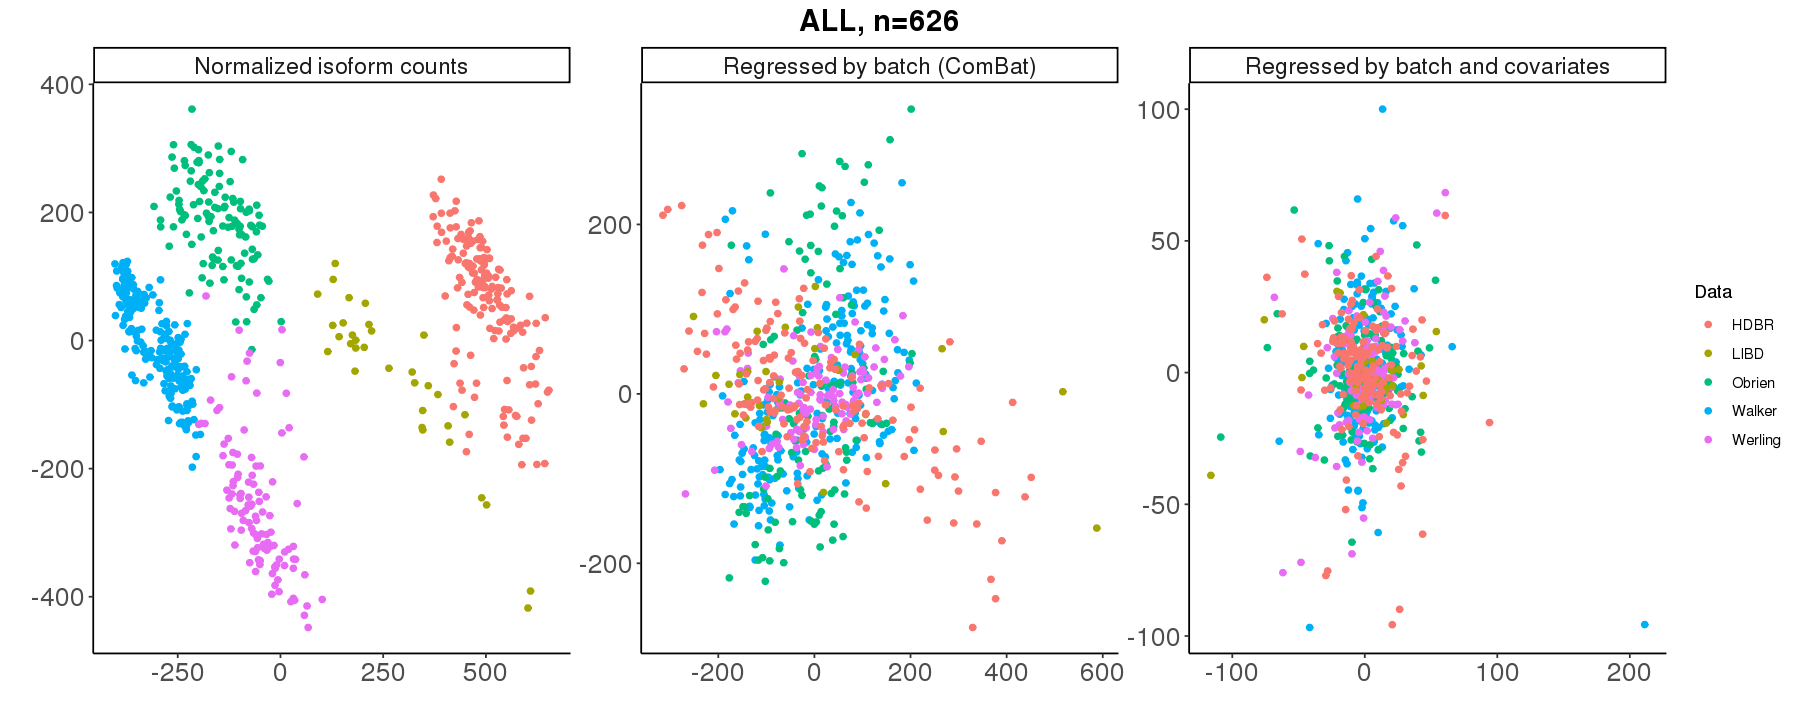

In [28]:
datExpr <- fread("data/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/70hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p1 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "ALL, n=626") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p1

In [8]:
# ggsave("figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("data/eur/tx.counts.processed.tsv", data.table = F):
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/eur/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 281 column names but the data has 282 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  67 277

[1] 127986    277

[1] 127986    277

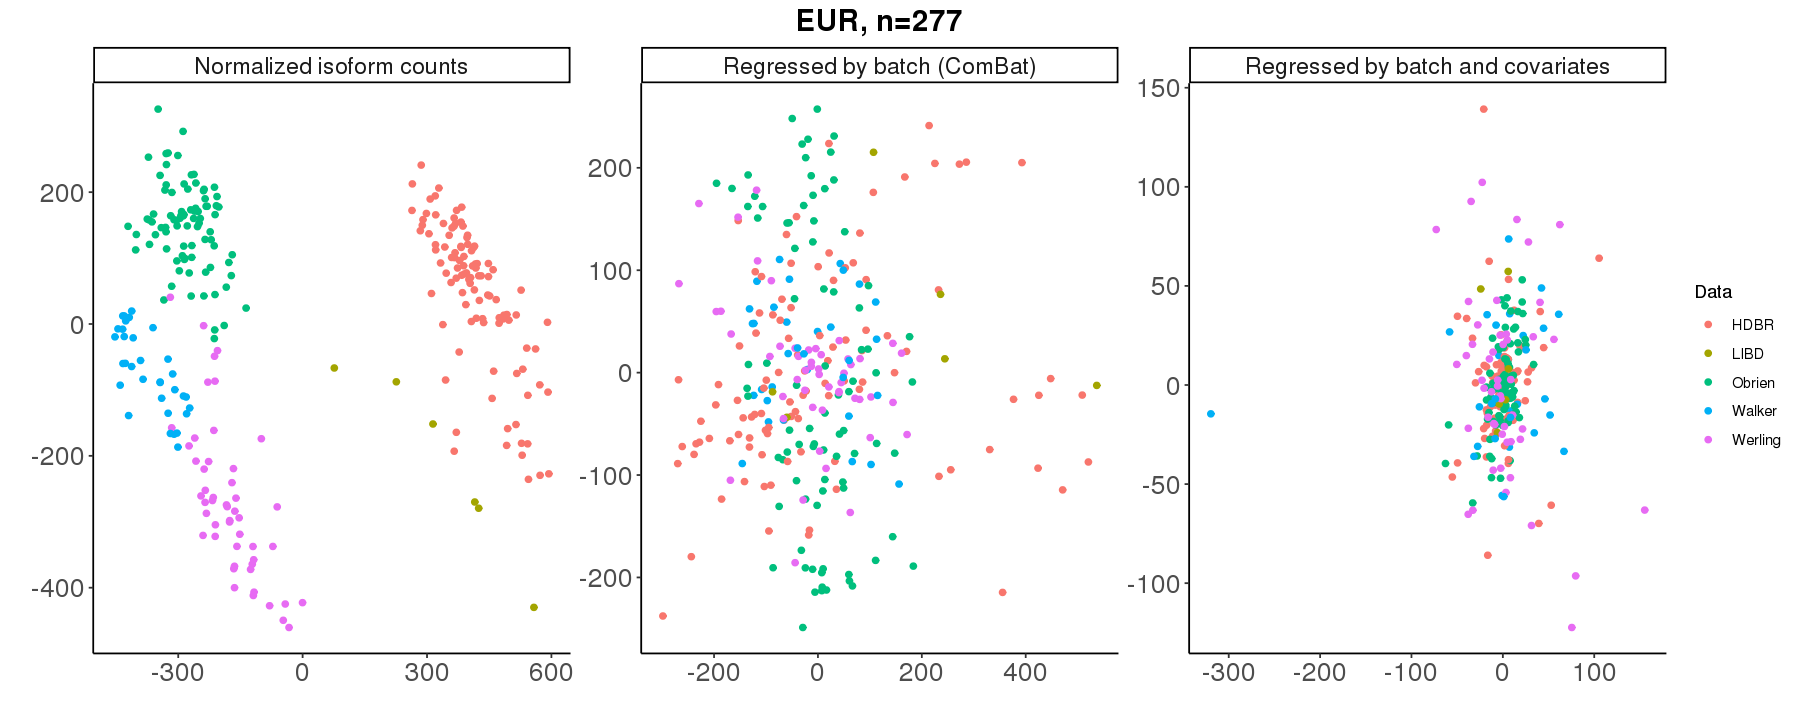

In [29]:
datExpr <- fread("data/eur/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/eur/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/eur/60HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "EUR, n=277") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [7]:
# ggsave("figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

Warning message in fread("data/amr/tx.counts.processed.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/amr/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 127986    162

[1] 127986    162

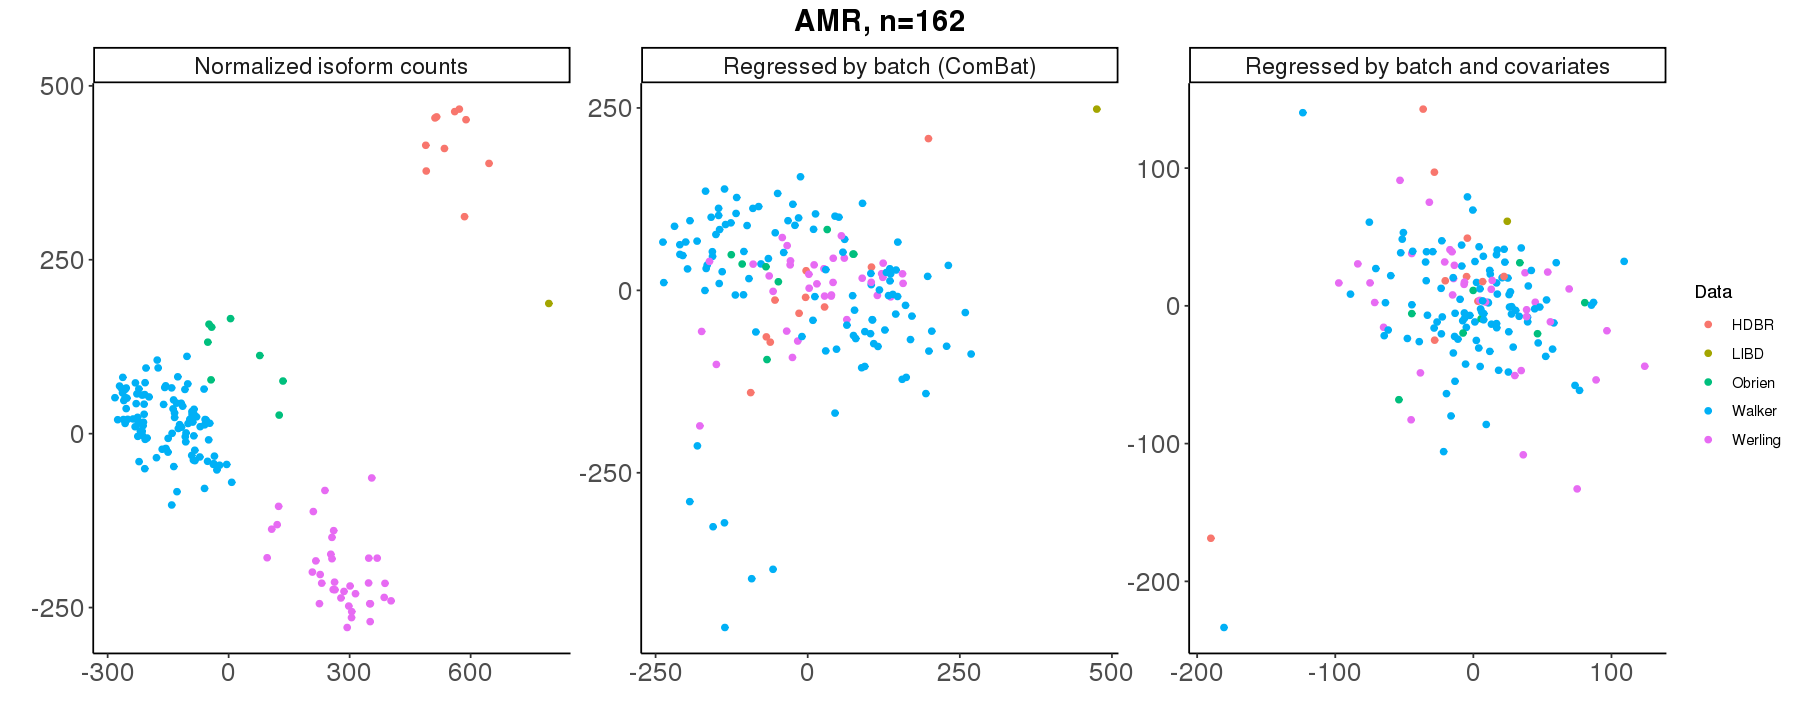

In [30]:
datExpr <- fread("data/amr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/amr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p3 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "AMR, n=162") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

In [6]:
# ggsave("figures/amr_regress.png", p7, width = 15, height = 6)

#### AFR

Warning message in fread("data/afr/tx.counts.processed.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/afr/tx.counts.processed.noComBat.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  27 135

[1] 127986    135

[1] 127986    135

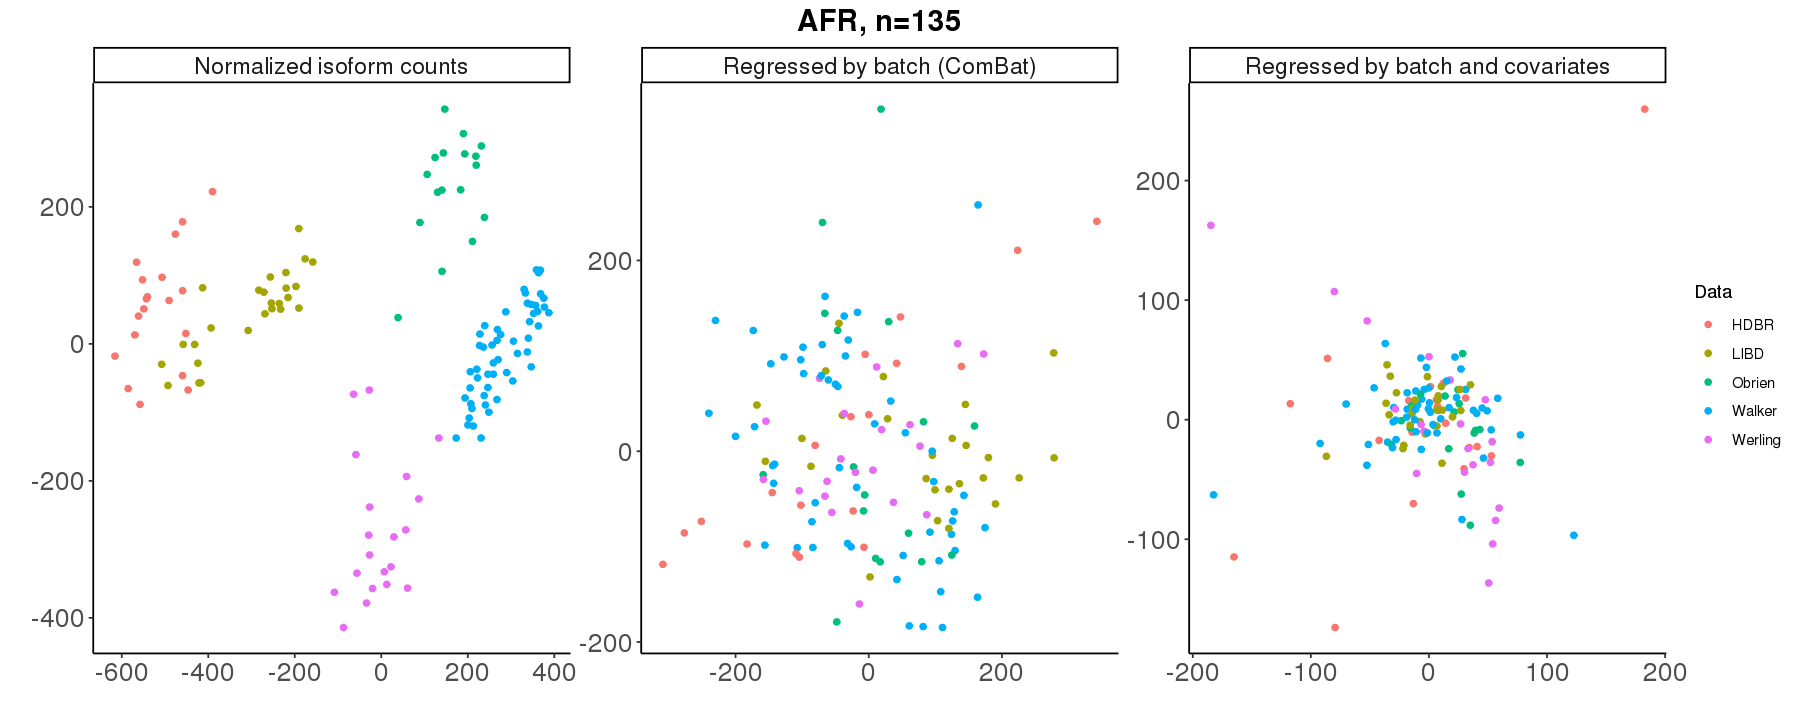

In [31]:
datExpr <- fread("data/afr/tx.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/afr/tx.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/afr/20HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized isoform counts", dim(data2)[1]))
p4 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "AFR, n=135") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p4

In [11]:
# ggsave("figures/afr_regress.png", p8, width = 15, height = 6)

In [32]:
options(repr.plot.width=15, repr.plot.height=24)

p <- p1 / p2 / p3 / p4 +
  plot_annotation(title = "PCA of isoform expression",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) 
#   plot_annotation(tag_level = 'A') &
#                  theme(plot.tag = element_text(size = 18, face = "bold"))

# p
ggsave("figures/regress.png", p, width = 15, height = 24)

### 4: Check beta-approximated permutation pval

[1] 0.9999

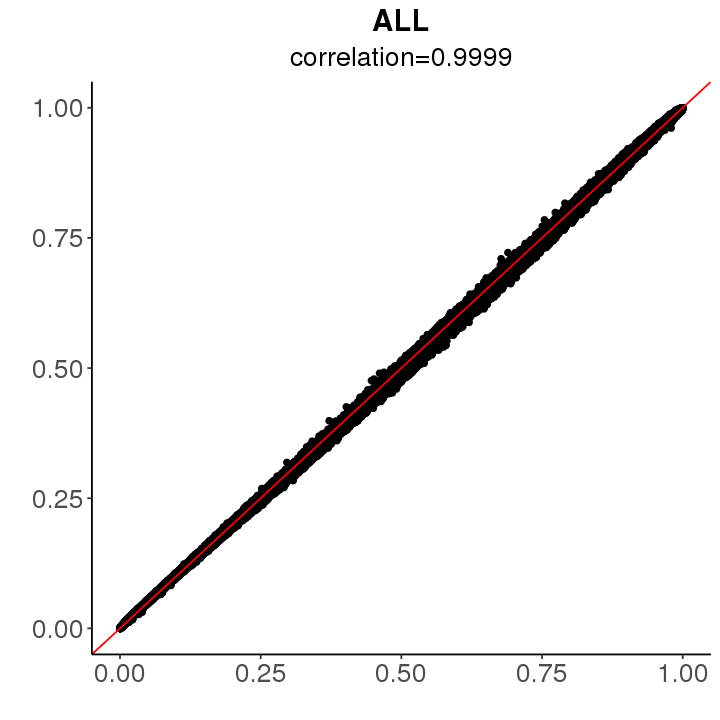

In [33]:
options(repr.plot.width=6, repr.plot.height=6)

mixed <- fread("results/mixed_perm_70hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(mixed[, 'ppval'], mixed[, 'bpval']), 4)
p1 <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "ALL",
         subtitle = "correlation=0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p1

In [11]:
# ggsave("figures/mixed_check.png", p, width = 6, height = 6)

[1] 0.9998

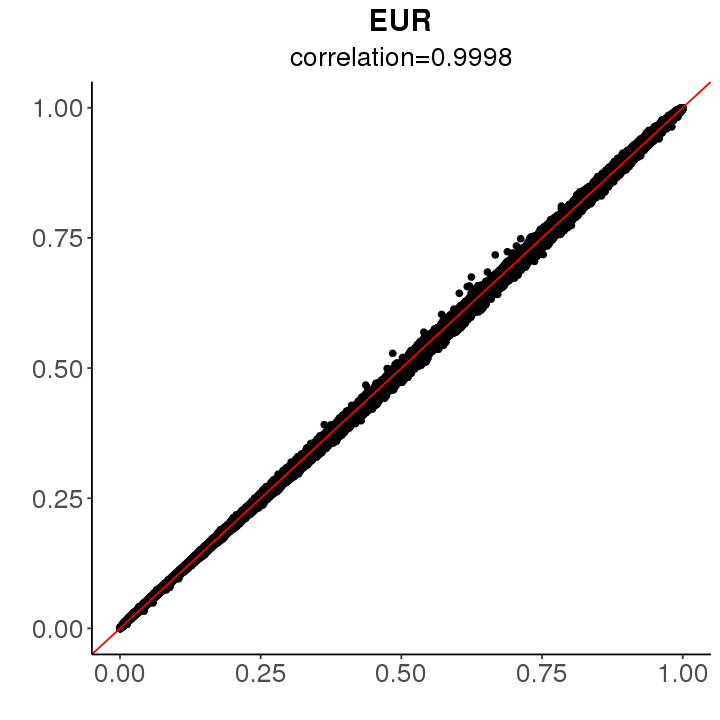

In [34]:
eur <- fread("results/eur_perm_60HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(eur[, 'ppval'], eur[, 'bpval']), 4)
p2 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "EUR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p2
# ggsave("figures/eur_check.png", p1, width = 6, height = 6)

[1] 0.9998

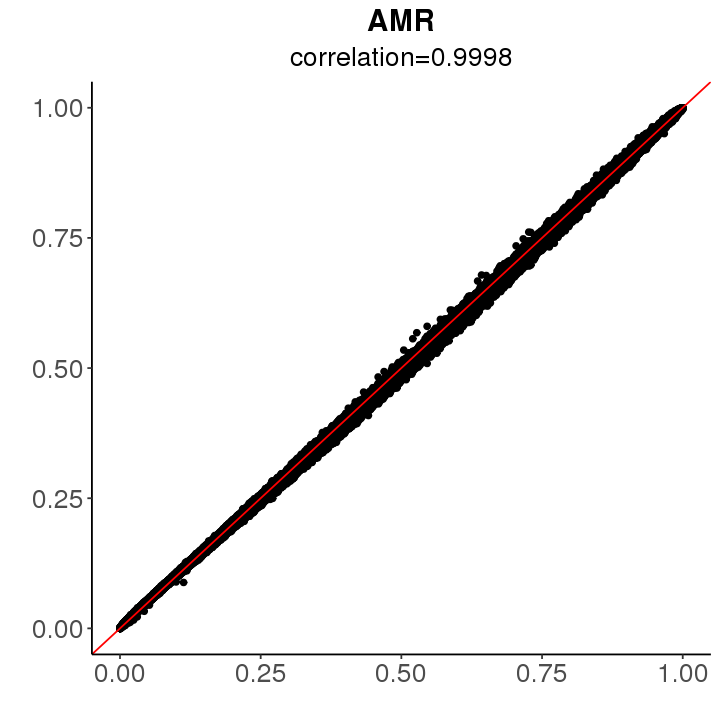

In [35]:
amr <- fread("results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(amr[, 'ppval'], amr[, 'bpval']), 4)
p3 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "AMR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p3
# ggsave("figures/amr_check.png", p2, width = 6, height = 6)

[1] 0.9998

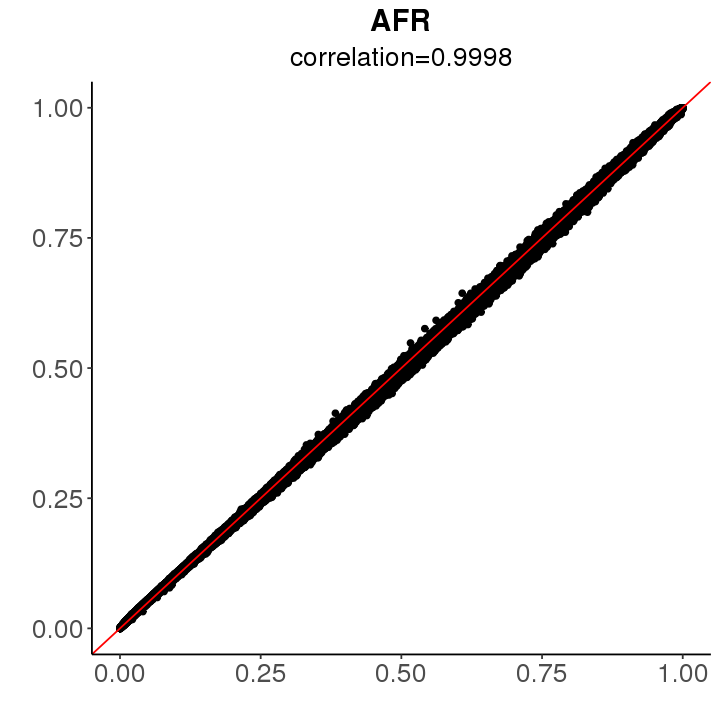

In [36]:
options(repr.plot.width=6, repr.plot.height=6)
afr <- fread("results/afr_perm_20HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(afr[, 'ppval'], afr[, 'bpval']), 4)
p4 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "AFR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p4
# ggsave("figures/afr_check.png", p3, width = 6, height = 6)

In [37]:
options(repr.plot.width=20, repr.plot.height=5)

p <- p1 + p2 + p3 + p4 +
  plot_annotation(title = "FastQTL cis-isoQTL check plot",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) +
  plot_layout(ncol = 4)

# p
ggsave("figures/check.png", p, width = 20, height = 5)

### 5: top isoQTL per isoform dTSS to its target isoform

In [3]:
mixed_sig <- read.table("results/mixed_perm_70hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc <- fread("results/mixed_perm_70hcp/all_assoc.txt.gz", data.table = F)

eur_sig <- read.table("results/eur_perm_60HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_eur <- fread("results/eur_perm_60HCP/all_assoc.txt.gz", data.table = F)

amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_amr <- fread("results/amr_perm_15HCP/all_assoc.txt.gz", data.table = F)

afr_sig <- read.table("results/afr_perm_20HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_afr <- fread("results/afr_perm_20HCP/all_assoc.txt.gz", data.table = F)

In [4]:
tx2gene <- read.table("../salmon/tx2gene_gencode_v33_noGeneVersion.tsv", header=T, stringsAsFactors=F)

In [5]:
mixed_sig <- mixed_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
eur_sig <- eur_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(eur_sig, "results/eur_perm_60HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
amr_sig <- amr_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(amr_sig, "results/amr_perm_15HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)
afr_sig <- afr_sig %>% left_join(tx2gene, by = c("pid" = "Tx"))
# write.table(afr_sig, "results/afr_perm_20HCP/sig_pheno_gene.txt", col.names=T, row.names=F, sep="\t", quote=F)

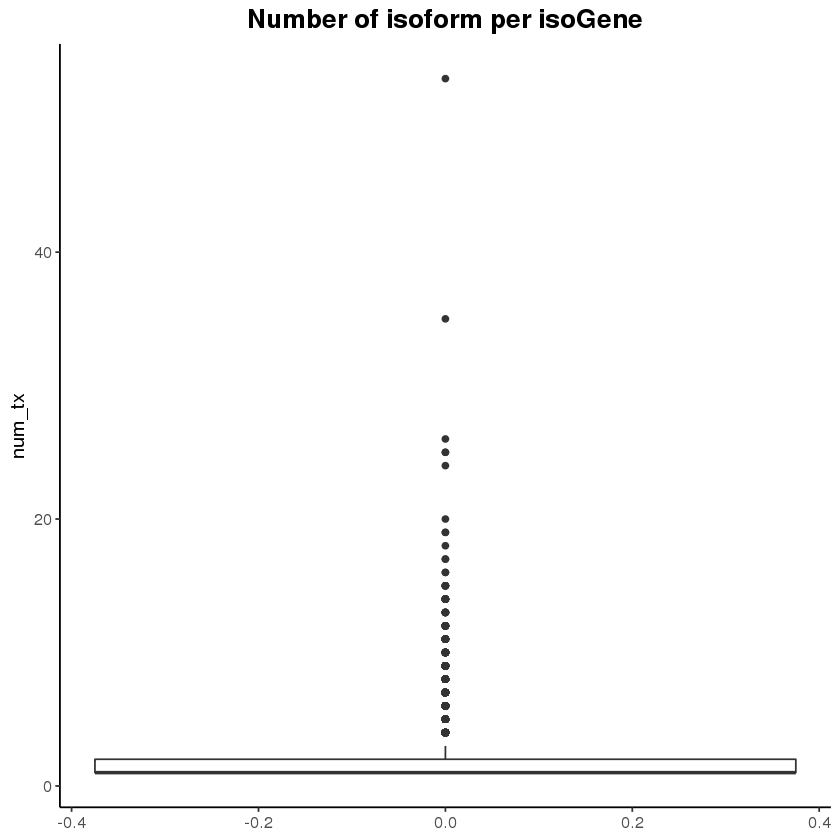

In [6]:
df <- data.frame("gene" <- unique(mixed_sig$Gene), "num_tx" <- NA)
colnames(df) <- c("gene", "num_tx")
for (i in 1:nrow(df)) {
    df[i,2] <- sum(mixed_sig$Gene == df[i,1])
}

p <- ggplot(df, aes(y=num_tx)) +
    geom_boxplot() +
    labs(title = "Number of isoform per isoGene") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5))
p

In [7]:
summary(df$num_tx)
head(df %>% arrange(desc(num_tx)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.996   2.000  53.000 

,gene,num_tx
,<fct>,<int>
1,ENSG00000242086,53
2,ENSG00000259905,35
3,ENSG00000224078,26
4,ENSG00000170919,25
5,ENSG00000197912,25
6,ENSG00000196295,24


In [8]:
# mixed_sig <- mixed_sig %>% arrange(Gene, bpval)
# top <- mixed_sig[!duplicated(mixed_sig$Gene),]

In [8]:
# mixed_sig$dist_kb <- mixed_sig$dist/1000
# p <- ggplot(mixed_sig, aes(x = dist_kb)) +
#     geom_density(color = "purple", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "Combined ancestry top cis-isoQTL per isoform") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p

In [9]:
# ggsave("figures/mixed_dist.png", p, height = 6, width = 6)

** sig vs non-sig **


non-significant     significant 
         103975           22891 

[1] 126866

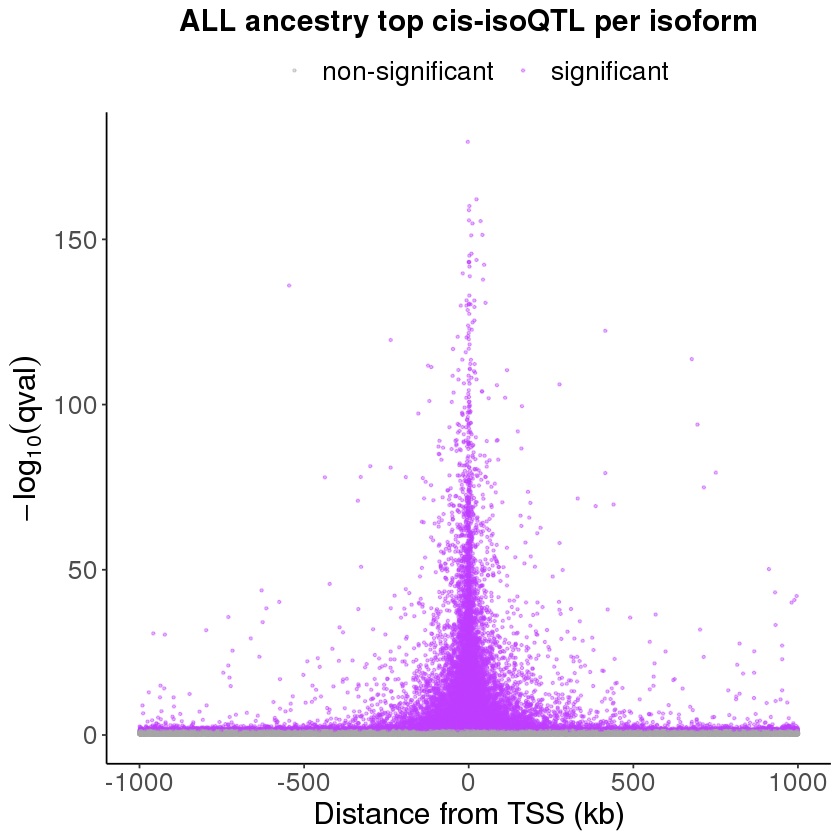

In [10]:
all_assoc <- all_assoc %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
all_assoc$sig <- as.factor(all_assoc$sig)

table(all_assoc$sig)
length(unique(all_assoc$pid))

all_assoc <- all_assoc %>% mutate(dist_kb = dist/1000)

p <- ggplot(all_assoc, aes(x=dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .4, size = .6) +
    labs(x = "Distance from TSS (kb)",
         y = expression(-log[10](qval)),
         title = "ALL ancestry top cis-isoQTL per isoform",
         color = "") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face="bold", hjust = 0.5),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 16),
         legend.position = "top") +
    scale_color_manual(values=c("grey65", "darkorchid1"))
p

In [11]:
ggsave("figures/mixed_dist_p.png", p, width = 6, height = 6)

In [12]:
# eur_sig$dist_kb <- eur_sig$dist/1000
# p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
#     geom_density(color = "purple", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "EUR top cis-isoQTL per isoform") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p1
# ggsave("figures/eur_dist.png", p1, height = 6, width = 6)

In [13]:
# amr_sig$dist_kb <- amr_sig$dist/1000
# p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
#     geom_density(color = "purple", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "AMR top cis-isoQTL per isoform") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p2
# ggsave("figures/amr_dist.png", p2, height = 6, width = 6)

In [14]:
# afr_sig$dist_kb <- afr_sig$dist/1000
# p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
#     geom_density(color = "purple", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "AFR top cis-isoQTL per isoform") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p3
# ggsave("figures/afr_dist.png", p3, height = 6, width = 6)

In [15]:
all_assoc_eur <- all_assoc_eur %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_eur$sig)
length(unique(all_assoc_eur$pid))
all_assoc_eur <- all_assoc_eur %>% mutate(dist_kb = dist/1000)
all_assoc_eur$sig <- as.factor(all_assoc_eur$sig)

all_assoc_amr <- all_assoc_amr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_amr$sig)
length(unique(all_assoc_amr$pid))
all_assoc_amr <- all_assoc_amr %>% mutate(dist_kb = dist/1000)
all_assoc_amr$sig <- as.factor(all_assoc_amr$sig)

all_assoc_afr <- all_assoc_afr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_afr$sig)
length(unique(all_assoc_afr$pid))
all_assoc_afr <- all_assoc_afr %>% mutate(dist_kb = dist/1000)
all_assoc_afr$sig <- as.factor(all_assoc_afr$sig)


non-significant     significant 
         115194           11672 

[1] 126866


non-significant     significant 
         121118            5747 

[1] 126865


non-significant     significant 
         123146            3719 

[1] 126865

In [16]:
all_assoc_eur_amr_afr <- rbind(all_assoc_eur, all_assoc_amr, all_assoc_afr)
all_assoc_eur_amr_afr$ancestry <- c(rep("EUR", nrow(all_assoc_eur)), 
                                    rep("AMR", nrow(all_assoc_amr)), 
                                    rep("AFR", nrow(all_assoc_afr)))
all_assoc_eur_amr_afr$ancestry <- factor(all_assoc_eur_amr_afr$ancestry, levels = c("EUR", "AMR", "AFR"))

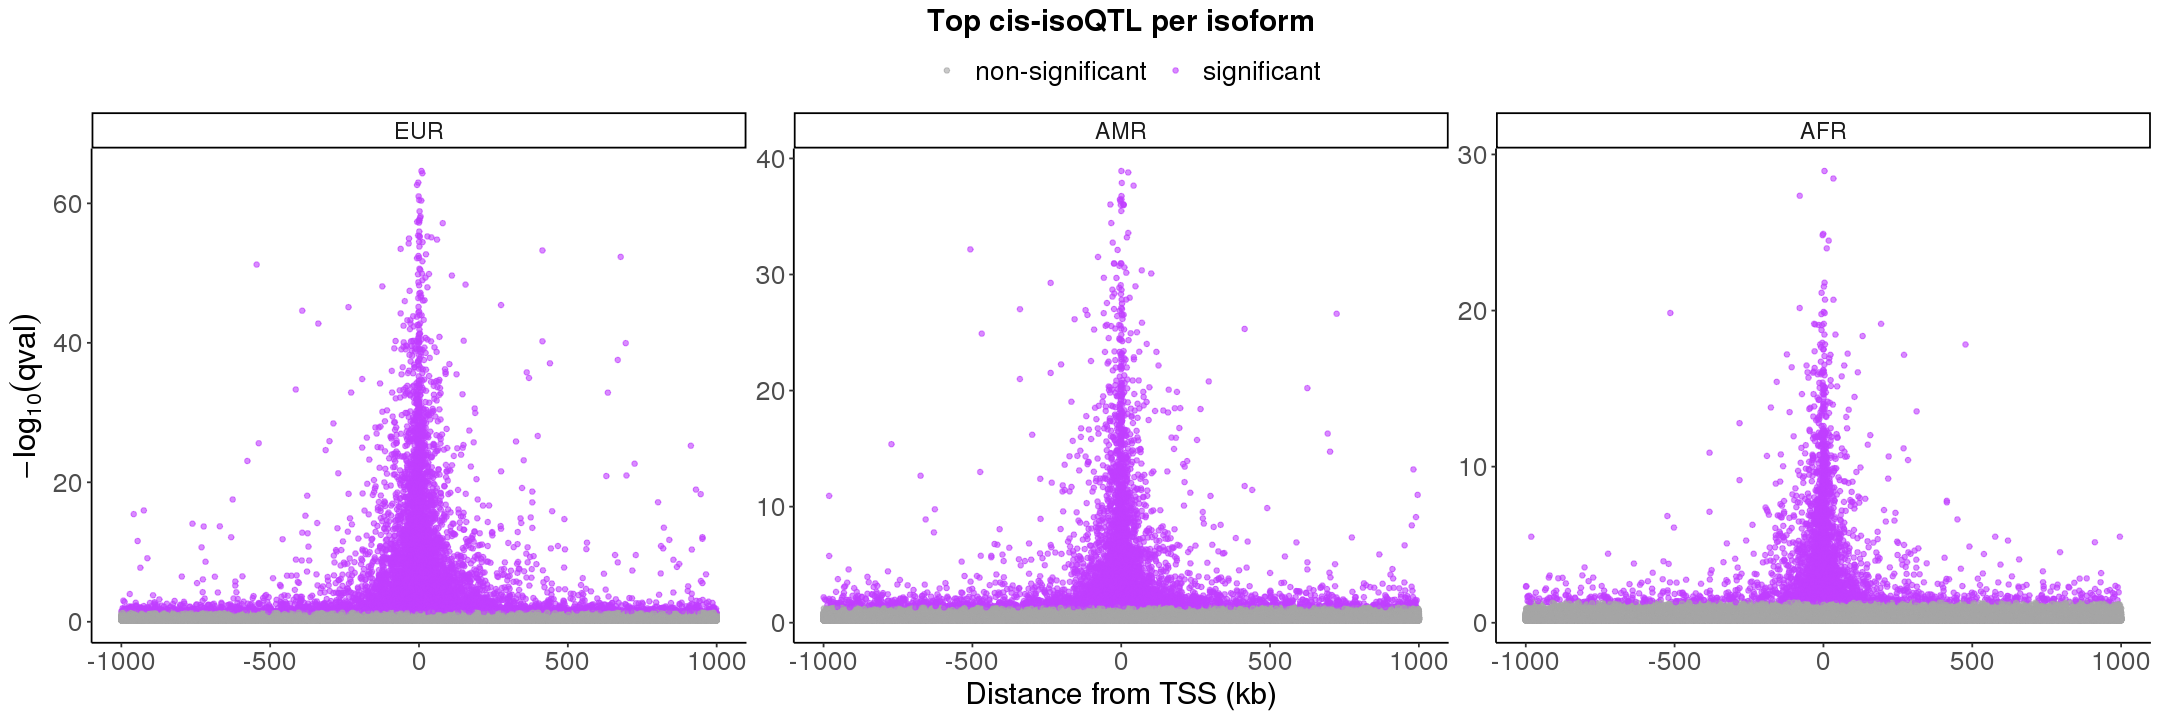

In [17]:
options(repr.plot.width=18, repr.plot.height=6)
p <- ggplot(all_assoc_eur_amr_afr, aes(x = dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .6, size = 1.2) +
    facet_wrap (~ancestry, scales = "free") +
    labs(x = "Distance from TSS (kb)",
         y = expression(-log[10](qval)),
         title = "Top cis-isoQTL per isoform",
         color = "") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 16),
         legend.position = "top",
         strip.text.x = element_text(size = 14)) +
    scale_color_manual(values=c("grey65", "darkorchid1")) 
p

In [18]:
ggsave("figures/dist.png", p, height = 6, width = 18)

**TODO: Share of isoQTL for isoforms of a gene**

In [19]:
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,Gene
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENST00000002165.11_3,5683,1.04270,863.673,478.732,rs4896658,-47658,1.04606e-17,-0.814467,0.00009999,2.84572e-13,3.88533e-12,2.30536e-05,ENSG00000001036
2,ENST00000002501.11_2,4247,1.08405,461.862,450.821,rs78536691,14607,8.12818e-07,-0.476499,0.00159984,2.08651e-03,8.58905e-03,5.10417e-05,ENSG00000003249
3,ENST00000002596.6_3,7427,1.04532,878.552,477.103,rs57203756,256802,2.62013e-06,-0.696909,0.00759924,7.96587e-03,2.76269e-02,2.29153e-05,ENSG00000002587
4,ENST00000003100.13_4,4221,1.01913,520.765,479.814,rs34040612,35125,3.26734e-15,-0.201914,0.00009999,5.24469e-11,5.89738e-10,3.45304e-05,ENSG00000001630
5,ENST00000003302.8_2,5184,1.04422,804.917,483.553,rs7126080,-21619,2.00629e-09,0.231246,0.00009999,8.26057e-06,5.23915e-05,2.48958e-05,ENSG00000048028
6,ENST00000003583.12_2,5651,1.05037,809.344,475.954,rs11578878,-9278,3.09987e-34,0.523475,0.00009999,1.96434e-28,7.14212e-27,2.54073e-05,ENSG00000001460


In [ ]:
# mixed_sig <- mixed_sig %>% group_by(Gene) %>% summarise(prop_share = )

### 6: Ancestry isoTx/isoGene UpsetR

In [21]:
mixed_tx <- unique(mixed_sig$pid)
eur_tx <- unique(eur_sig$pid)
amr_tx <- unique(amr_sig$pid)
afr_tx <- unique(afr_sig$pid)

tx <- list(ALL = mixed_tx,
            EUR = eur_tx,
            AMR = amr_tx,
            AFR = afr_tx)

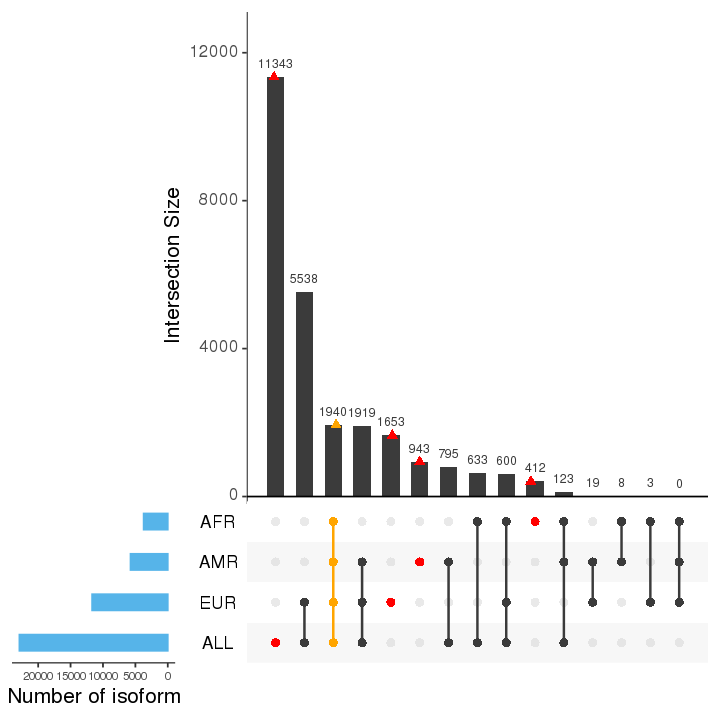

In [26]:
options(repr.plot.width = 6, repr.plot.height = 6)
upset(fromList(tx), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoform",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("ALL"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [27]:
pdf(file="figures/upsetr_isotx.pdf", onefile=F)
upset(fromList(tx), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoform",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("ALL"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

In [28]:
mixed_gene <- unique(mixed_sig$Gene)
eur_gene <- unique(eur_sig$Gene)
amr_gene <- unique(amr_sig$Gene)
afr_gene <- unique(afr_sig$Gene)

genes <- list(ALL = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

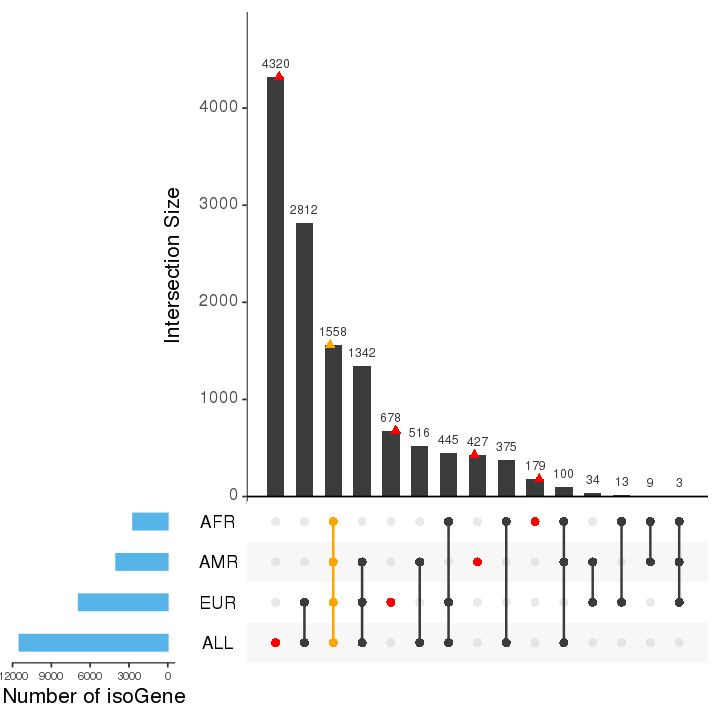

In [29]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("ALL"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))

In [30]:
pdf(file="figures/upsetr_isogene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of isoGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","ALL"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("ALL"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.2))
dev.off()

png 
  2

**Correlation of isoQTL effect sizes**

In [79]:
mixed_nominal <- fread("results/mixed_nominal_70hcp/significant_assoc.txt", data.table = F)
eur_nominal <- fread("results/eur_nominal_60HCP/significant_assoc.txt", data.table = F)
amr_nominal <- fread("results/amr_nominal_15HCP/significant_assoc.txt", data.table = F)
afr_nominal <- fread("results/afr_nominal_20HCP/significant_assoc.txt", data.table = F)

In [80]:
# Note "gene" is actually isoform here, copied from eQTL
mixed_nominal <- mixed_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
eur_nominal <- eur_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_nominal <- amr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_nominal <- afr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [81]:
# mixed, eur
mixed_eur <- mixed_nominal %>% inner_join(eur_nominal, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')
# mixed, amr
mixed_amr <- mixed_nominal %>% inner_join(amr_nominal, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')
# mixed, afr
mixed_afr <- mixed_nominal %>% inner_join(afr_nominal, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')
# eur, amr
eur_amr <- eur_nominal %>% inner_join(amr_nominal, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')
# eur, afr
eur_afr <- eur_nominal %>% inner_join(afr_nominal, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')
# amr, afr
amr_afr <- amr_nominal %>% inner_join(afr_nominal, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [82]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_nominal), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_nominal), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_nominal), nrow(amr_afr),
                             nrow(afr_nominal)))
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df

group1,group2,rho,shared,display
<fct>,<fct>,<dbl>,<int>,<chr>
ALL,ALL,1.0000000,3133855,1 (3133855)
ALL,EUR,0.8871040,1215166,0.8871 (1215166)
ALL,AMR,0.8442195,486280,0.8442 (486280)
ALL,AFR,0.8410881,182758,0.8411 (182758)
EUR,EUR,1.0000000,1512003,1 (1512003)
EUR,AMR,0.7840625,361381,0.7841 (361381)
EUR,AFR,0.7746984,120344,0.7747 (120344)
AMR,AMR,1.0000000,578845,1 (578845)
AMR,AFR,0.8074282,107379,0.8074 (107379)


In [83]:
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

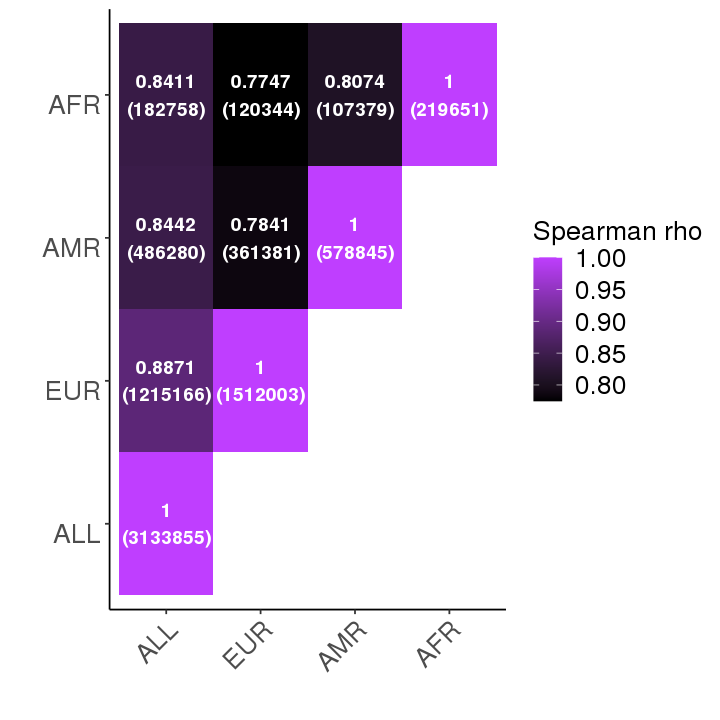

In [84]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
    geom_tile() +
 scale_fill_gradient( 
   name = "Spearman rho",
   low = "black", high = "darkorchid1") +
 theme_classic() + 
 labs(x = "", y = "") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 16, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 16, hjust = 1),
       axis.title = element_text(size = 18),
       plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 16),
      legend.position = "right") +
#  ggtitle("Correlation of nominal isoQTL effect size") +
 geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [85]:
ggsave("figures/corr_nominal.png", p, width = 6, height = 6)

In [38]:
mixed_sig <- mixed_sig %>% unite("gene_snp", pid, sid, sep = "-",remove = FALSE)
eur_sig <- eur_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_sig <- amr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_sig <- afr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [39]:
mixed_eur <- mixed_sig %>% inner_join(eur_sig, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')

mixed_amr <- mixed_sig %>% inner_join(amr_sig, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')

mixed_afr <- mixed_sig %>% inner_join(afr_sig, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')

eur_amr <- eur_sig %>% inner_join(amr_sig, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')

eur_afr <- eur_sig %>% inner_join(afr_sig, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')

amr_afr <- amr_sig %>% inner_join(afr_sig, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [40]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_sig), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_sig), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_sig), nrow(amr_afr),
                             nrow(afr_sig)))

In [41]:
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

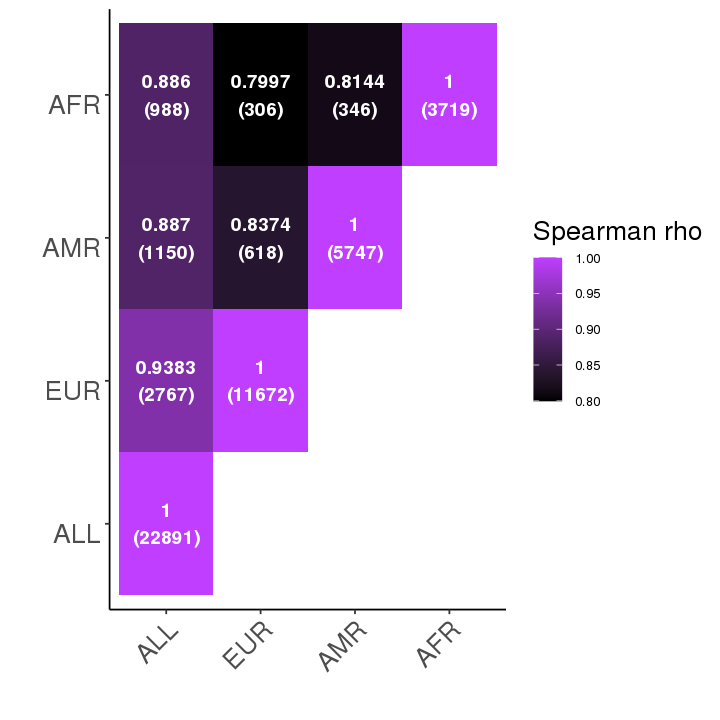

In [43]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
    geom_tile() +
 scale_fill_gradient( 
   name="Spearman rho",
   low = "black", high = "darkorchid1") +
 theme_classic() + 
 labs(x = "", y = "") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 16, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 16, hjust = 1),
       axis.title = element_text(size = 18),
       plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 8),
      legend.position = "right") +
#  ggtitle("Correlation of permutation isoQTL effect size") +
 geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [44]:
ggsave("figures/corr_perm.png", p, width = 6, height = 6)

### 7: Compare with PEC

### 8: isoGene types

In [45]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [46]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("Gene"="ensg"))

In [47]:
# no dist_kb column, ncol=26
dim(mixed_sig)

[1] 22891    27

In [14]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"

In [20]:
write.table(mixed_sig, "results/mixed_perm_70hcp/sig_pheno_gene_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [15]:
mixed_sig <- mixed_sig[!duplicated(mixed_sig$Gene),]

In [16]:
dim(mixed_sig)

[1] 11468    16

In [17]:
df <- as.data.frame(sort(table(mixed_sig$gene_type)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df

,Var1,Freq
,<fct>,<int>
25,protein_coding,8074
24,lncRNA,2207
23,processed_pseudogene,323
22,transcribed_unprocessed_pseudogene,238


** Write output file with gene name and gene type for all permutation associations **

Note: w/o `dtss_kb` column

In [21]:
all_assoc <- all_assoc %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_eur <- all_assoc_eur %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_amr <- all_assoc_amr %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))
all_assoc_afr <- all_assoc_afr %>% left_join(annot, by=c("Gene"="ensg")) %>% select(c(1:14, 25, 26))

In [24]:
colnames(all_assoc)[15] <- "gene_type"
colnames(all_assoc)[16] <- "gene_name"
colnames(all_assoc_eur)[15] <- "gene_type"
colnames(all_assoc_eur)[16] <- "gene_name"
colnames(all_assoc_amr)[15] <- "gene_type"
colnames(all_assoc_amr)[16] <- "gene_name"
colnames(all_assoc_afr)[15] <- "gene_type"
colnames(all_assoc_afr)[16] <- "gene_name"

In [25]:
write.table(all_assoc, "results/mixed_perm_70hcp/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_eur, "results/eur_perm_60HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_amr, "results/amr_perm_15HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_afr, "results/afr_perm_20HCP/all_assoc_perm_gene_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")

### 8: Conditional isoQTL

** Top variants per rank of all expressed isoforms **

In [48]:
dat <- fread("results/mixed_conditional_70hcp/conditional_top_variants.txt", data.table = F)

** Check TSS **

In [4]:
dim(dat)
sum(dat$V3+dat$V7==dat$V10)
sum(dat$V3+dat$V7==dat$V11)
sum(!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11))

[1] 32062    20

[1] 30939

[1] 30967

[1] 0

In [5]:
dat %>% filter(V7 == 0)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
ENST00000586591.1_1,18,12438889,12438889,+,7025,0,rs12964631,18,12438889,12438889,1,1.30434e-12,-0.399292,1,1,1.59533e-14,-0.430788,1,1
ENST00000463848.1_1,7,891187,891187,+,7647,0,chr7:851547,7,891184,891187,0,2.80785e-18,-0.556015,1,1,2.80785e-18,-0.556015,1,1
ENST00000527128.5_1,9,100000731,100000731,+,5358,0,rs7856254,9,100000731,100000731,0,2.32361e-14,1.277140,1,1,2.32361e-14,1.277140,1,1


In [6]:
table(dat$V19)
table(dat$V20)


    1 
32062 


    0     1 
   16 32046 

** remove variants with backward P-value that is not below the threshold of this feature **

In [49]:
dat <- dat %>% filter(V20 == 1)

** check features with significant conditional QTL are mostly isoforms with permutation isoQTL **

In [50]:
length(unique(mixed_sig$pid))
length(unique(dat$V1))
sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 22891

[1] 24122

[1] 20246

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [51]:
table(dat$V12)


    0     1     2     3     4     5     6     7 
24108  5611  1577   527   157    47    16     3 


    1     2     3     4     5     6     7     8 
18506  4033  1054   371   111    31    13     3 

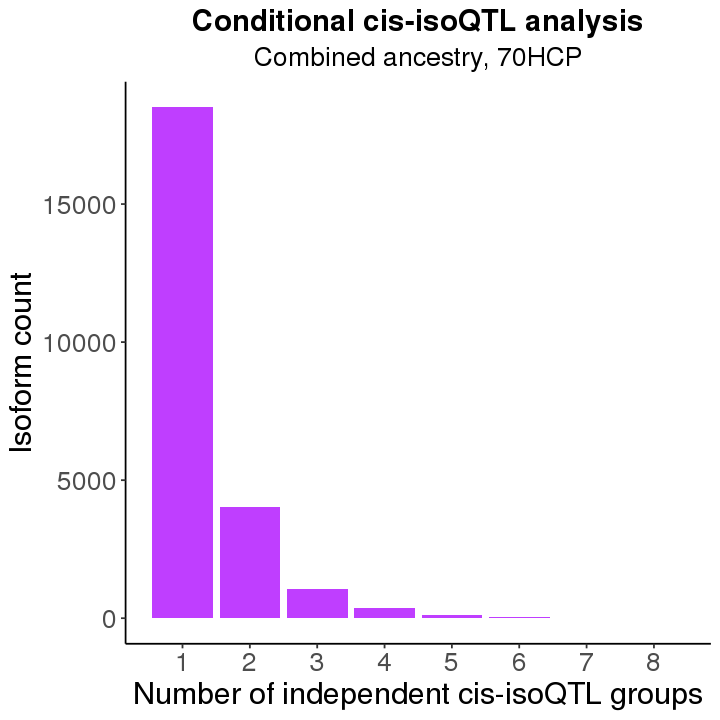

In [52]:
df_cond <- data.frame("isoform" <- unique(dat$V1),
                      "num_rank" <- NA)
for (i in 1:nrow(df_cond)) {
  isoform <- df_cond[i,1]
  df_cond[i,2] <- max(dat[dat$V1==isoform,12]) + 1
}
names(df_cond) <-c("isoform","num_rank")
table(df_cond$num_rank)

p <- ggplot(df_cond, aes(x=num_rank)) +
  geom_bar(fill="darkorchid1") +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  labs(x="Number of independent cis-isoQTL groups", y="Isoform count") +
  ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust=0.5),
        plot.subtitle = element_text(size = 16, hjust = 0.5))
p

In [53]:
ggsave("figures/condition_rank.png", p, height=6, width=6)

**Primary and seconday distance to TSS**

In [54]:
dat2 <- filter(dat, V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0, "Primary", "Secondary")

# p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
#   geom_density(size=.8) +
#   labs(x="Distance from TSS (kb)") +
#   ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
#   theme_classic() +
#   theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust=0.5),
#         plot.subtitle = element_text(size=14, hjust=0.5))
# p2

In [55]:
# ggsave("figures/condition_dtss.png", p2, height=6, width=6)

In [56]:
table(dat2$Rank)


  Primary Secondary 
    24108      5611 

In [57]:
primary <- dat2 %>% filter(Rank == "Primary")
secondary <- dat2 %>% filter(Rank == "Secondary")
median(primary$tss_kb)
median(secondary$tss_kb)

[1] -0.045

[1] 0.044

In [58]:
wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 53391678, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


** 1st-4th **

In [59]:
dat3 <- filter(dat, V12 <= 3)
dat3$tss_kb <- dat3$V7/1000
dat3 %>% group_by(V12) %>% summarise(median(tss_kb), mean(tss_kb))

`summarise()` ungrouping output (override with `.groups` argument)



V12,median(tss_kb),mean(tss_kb)
<int>,<dbl>,<dbl>
0,-0.045,-0.9788922
1,0.044,3.8704773
2,3.841,3.6104451
3,-7.573,-6.3737078


In [60]:
dat3 <- dat3 %>% mutate(Rank = case_when(V12 == 0 ~ "Primary, median=-0.045, mean=-0.979",
                                 V12 == 1 ~ "Secondary, median=0.044, mean=3.870",
                                 V12 == 2 ~ "Tertiary, median=3.841, mean=3.610",
                                 V12 == 3 ~ "Quaternary, median=-7.573, mean=-6.373"))
table(dat3$Rank)
dat3$Rank <- factor(dat3$Rank, levels = c("Primary, median=-0.045, mean=-0.979", 
                                          "Secondary, median=0.044, mean=3.870", 
                                          "Tertiary, median=3.841, mean=3.610", 
                                          "Quaternary, median=-7.573, mean=-6.373"))


   Primary, median=-0.045, mean=-0.979 Quaternary, median=-7.573, mean=-6.373 
                                 24108                                    527 
   Secondary, median=0.044, mean=3.870     Tertiary, median=3.841, mean=3.610 
                                  5611                                   1577 

In [61]:
# p <- ggplot(dat3, aes(x=tss_kb, y=Rank, fill=Rank)) +
#     geom_density_ridges(quantile_lines = TRUE, quantiles = 2, alpha = .2) +
#     theme_classic()
# p

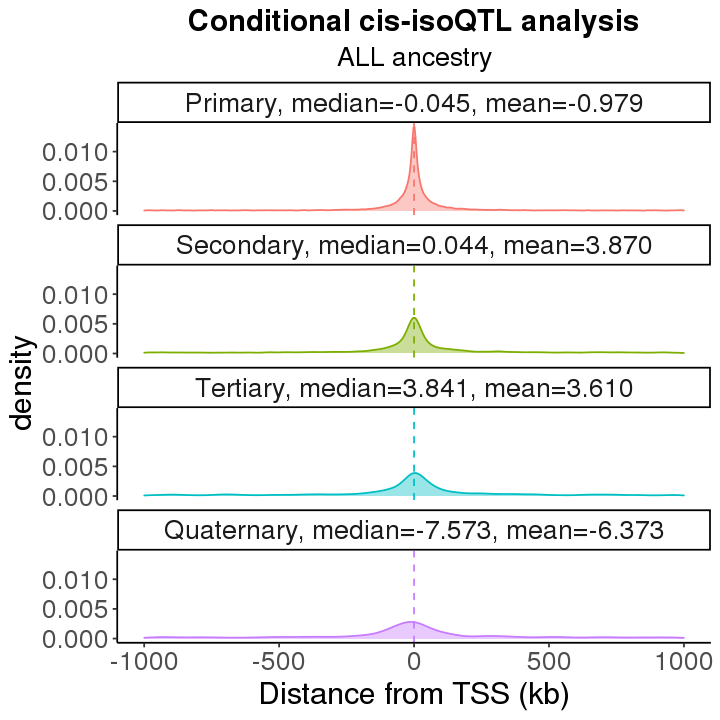

In [62]:
p2 <- ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
  geom_density(alpha = .4) +
  geom_vline(aes(xintercept=median(tss_kb), color = Rank), linetype = 2, size = .5) +
  facet_wrap(~Rank, nrow = 4) +
  labs(x="Distance from TSS (kb)") +
  ggtitle("Conditional cis-isoQTL analysis", subtitle = "ALL ancestry") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        axis.title = element_text(size=18),
        plot.title = element_text(size=18, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=16, hjust=0.5),
        legend.position="none",
        strip.text.x = element_text(size=16))
p2

In [63]:
ggsave("figures/condition_dtss_4.png", p2, width = 6, height = 6)

In [64]:
# p2 <- ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
#   geom_density(alpha = .4) +
#   labs(x="Distance from TSS (kb)") +
#   ggtitle("Conditional cis-isoQTL analysis", subtitle = "Combined ancestry, 70HCP") +
#   theme_classic() +
#   theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust=0.5),
#         plot.subtitle = element_text(size=14, hjust=0.5))
# p2

### 9: SuSiE results

- We started with 22891 isoTx identified by FastQTL permutation pass for mixed ancestries with 70 HCP in covariates
- After filtering for CS purity: 
    - 18111 isoforms have non-low purity CS
    - 23211 unique CS
    - 225,218 unique variants in CS    
- Of the 23211 CS:
    - 4702 contain exactly one SNP (strong candidates for causal variants)
    - 2614 contain exactly two SNPs
    - median size 5
- Of the 18111 isoforms:
    - 14380 have exactly one CS
    - up to 7

** File: all variants that belong to a non-low purity credible set **

Other files: 
- all credible sets (not filtered for purity)
- all tested variants

In [65]:
var_in_cs <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm.txt.gz", data.table = F)
dim(var_in_cs)

[1] 423607     17

** How many isoforms got finemapped non-low purity credible sets?**

In [4]:
length(unique(var_in_cs$phenotype_id))

[1] 18111

** How many unique variants in all CS? **

In [5]:
length(unique(var_in_cs$variant_id))

[1] 225218

** How many unique non-low purity CS?**

In [6]:
length(unique(var_in_cs$cs_id))

[1] 23211

**  Sorted by chr and pos of isoforms **

In [66]:
sorted_df <- fread("results/susie_finemap/mixed_cisisoqtl_70hcp_perm_purity_filtered.txt.gz", data.table = F)

** How many CS contain exactly one SNP? **

In [67]:
cs_id_size <- sorted_df[!duplicated(sorted_df$cs_id),] %>% select(cs_id, cs_size, finemapped_region)

In [68]:
sum(cs_id_size$cs_size==1)
sum(cs_id_size$cs_size==2)

[1] 4702

[1] 2614

In [69]:
summary(cs_id_size$cs_size)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    5.00   18.25   15.00 2164.00 

** Note chr 17 region has large CS **

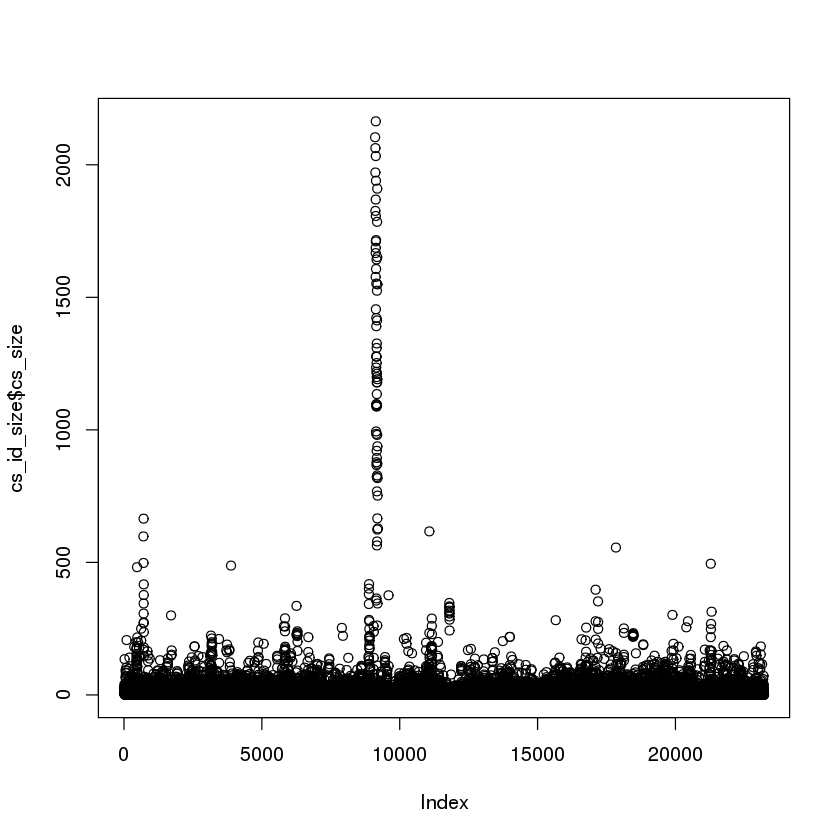

In [12]:
plot(cs_id_size$cs_size)

In [13]:
cs_id_size %>% filter(cs_size > 500)

cs_id,cs_size,finemapped_region
<chr>,<int>,<chr>
ENST00000621900.1_1_L1,598,chr10:73885289-75885289
ENST00000488223.5_1_L1,665,chr10:73870216-75870216
ENST00000587960.1_1_L3,2104,chr17:42608942-44608942
ENST00000329196.7_2_L1,1826,chr17:42922246-44922246
ENST00000585677.1_1_L1,1971,chr17:42716340-44716340
ENST00000570299.5_1_L1,2063,chr17:42971941-44971941
ENST00000638269.1_2_L2,1577,chr17:43302726-45302726
ENST00000592428.1_2_L1,1667,chr17:42716802-44716802
ENST00000577114.2_3_L2,1869,chr17:43198703-45198703


** How many isoforms have exactly one CS? **

In [70]:
iso_with_cs <- unique(sorted_df$phenotype_id)
df <- data.frame("isoform" = iso_with_cs,
                 "cs_count" = NA)
for(i in 1:nrow(df)) {
    df[i,2] <- length(unique(sorted_df[sorted_df$phenotype_id == df[i,1],]$cs_id))
}

In [71]:
summary(df$cs_count)
sum(df$cs_count == 1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.282   1.000   7.000 

[1] 14380

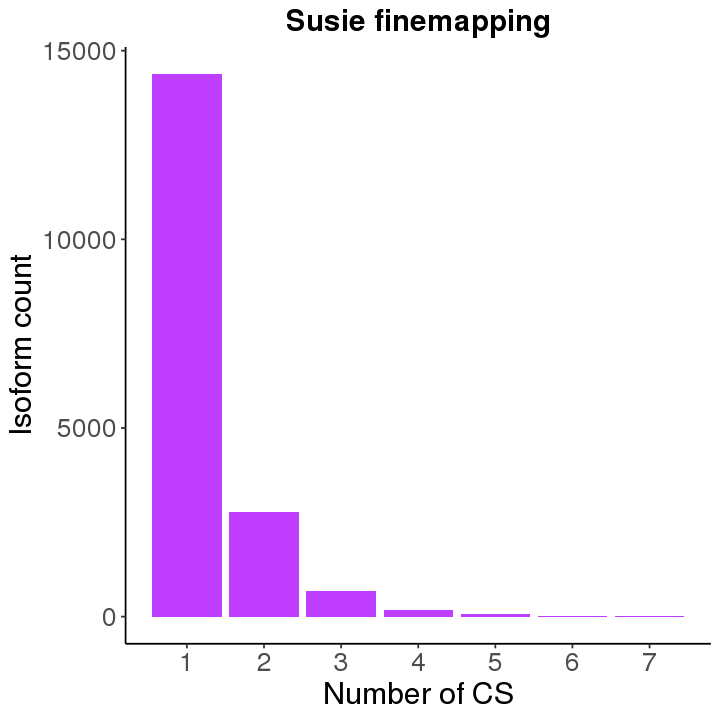

In [72]:
p <- ggplot(df, aes(x=cs_count)) +
  geom_bar(fill="darkorchid1") +
  scale_x_continuous(breaks = seq(1,7,by=1)) +
  labs(x="Number of CS", y="Isoform count") +
  ggtitle("Susie finemapping") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5))
p

In [73]:
ggsave("figures/susie_num_cs.png", p, width = 6, height = 6)

** Number of independent signals compared to conditional QTL mapping**

In [74]:
sum(df$isoform %in% df_cond$isoform)

[1] 17027

In [75]:
df2 <- df %>% inner_join(df_cond)
sum(complete.cases(df2))
dim(df2)

Joining, by = "isoform"



[1] 17027

[1] 17027     3

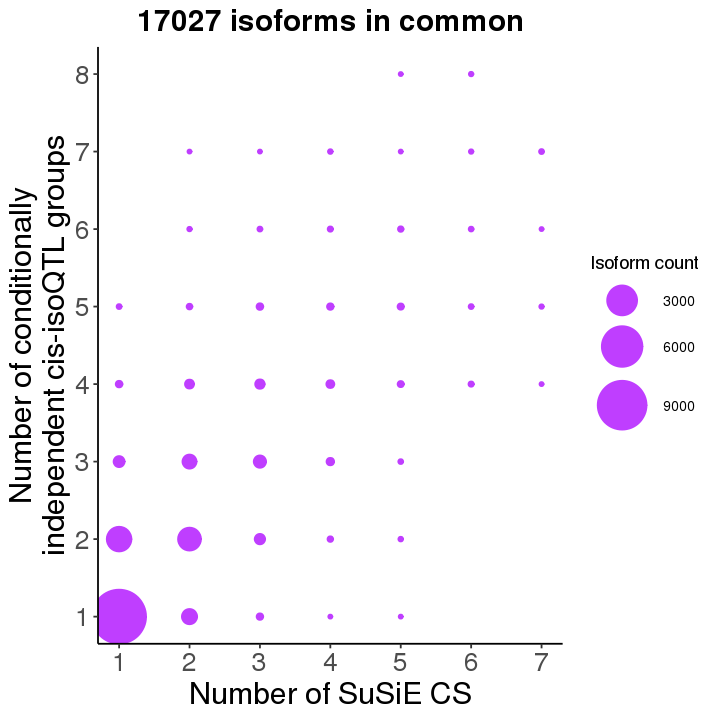

In [77]:
p <- ggplot(df2, aes(x=cs_count, y=num_rank)) +
  geom_count(color = "darkorchid1") +
#   geom_count(aes(color = ..n..), size=5) +
  scale_size(range = c(1, 15), "Isoform count") + 
#   geom_hex() +
  labs(x="Number of SuSiE CS", y="Number of conditionally\nindependent cis-isoQTL groups") +
  ggtitle("17027 isoforms in common") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5)) +
  scale_x_continuous(breaks = seq(1,8,by=1)) +
  scale_y_continuous(breaks = seq(1,10,by=1)) 
p

In [78]:
ggsave("figures/susie_conditional.png", p, width=6, height=6)

** sum of PIP in CS **

In [33]:
cs_sum_pip <- sorted_df %>% group_by(cs_id) %>% summarise(sum_pip = sum(pip))
summary(cs_sum_pip)

`summarise()` ungrouping output (override with `.groups` argument)



    cs_id              sum_pip      
 Length:23211       Min.   :0.9500  
 Class :character   1st Qu.:0.9639  
 Mode  :character   Median :0.9777  
                    Mean   :0.9815  
                    3rd Qu.:0.9978  
                    Max.   :1.8221  